## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5]
redice_lr_patient = [5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 4s 75us/step - loss: 1.6265 - accuracy: 0.4298 - val_loss: 1.6998 - val_accuracy: 0.3988
Epoch 11/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.6061 - accuracy: 0.4366 - val_loss: 1.6833 - val_accuracy: 0.4086
Epoch 12/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.5857 - accuracy: 0.4435 - val_loss: 1.6765 - val_accuracy: 0.4098
Epoch 13/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.5682 - accuracy: 0.4506 - val_loss: 1.6620 - val_accuracy: 0.4158
Epoch 14/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.5518 - accuracy: 0.4549 - val_loss: 1.6526 - val_accuracy: 0.4172
Epoch 15/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5367 - accuracy: 0.4630 - val_loss: 1.6458 - val_accuracy: 0.4232
Epoch 16/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.5223 - accuracy: 0.4662 - val_loss: 1.6369

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 81us/step - loss: 2.5928 - accuracy: 0.1893 - val_loss: 2.2139 - val_accuracy: 0.1833
Epoch 2/25
50000/50000 [==============================] - 4s 74us/step - loss: 2.1101 - accuracy: 0.2916 - val_loss: 2.1187 - val_accuracy: 0.2428
Epoch 3/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.9460 - accuracy: 0.3354 - val_loss: 2.0172 - val_accuracy: 0.2976
Epoch 4/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.8554 - accuracy: 0.3603 - val_loss: 1.9230 - val_accuracy: 0.3340
Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.7956 - accuracy: 0.3789 - val_loss: 1.8377 - val_accuracy: 0.3618
Epoch 6/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.7489 - accuracy: 0.3945 - val_loss: 1.7892 - val_accuracy: 0.3781
Epoch 7/25
50000/50000 [==============================] - 3s 68us/st

50000/50000 [==============================] - 3s 70us/step - loss: 0.5049 - accuracy: 0.8475 - val_loss: 1.4894 - val_accuracy: 0.5279
Epoch 21/25
50000/50000 [==============================] - 4s 70us/step - loss: 0.4881 - accuracy: 0.8529 - val_loss: 1.5093 - val_accuracy: 0.5257
Epoch 22/25
50000/50000 [==============================] - 4s 70us/step - loss: 0.4717 - accuracy: 0.8608 - val_loss: 1.5251 - val_accuracy: 0.5220

Epoch 00022: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 23/25
50000/50000 [==============================] - 4s 70us/step - loss: 0.4341 - accuracy: 0.8779 - val_loss: 1.4848 - val_accuracy: 0.5428
Epoch 24/25
50000/50000 [==============================] - 4s 73us/step - loss: 0.4248 - accuracy: 0.8833 - val_loss: 1.4932 - val_accuracy: 0.5379
Epoch 25/25
50000/50000 [==============================] - 4s 73us/step - loss: 0.4204 - accuracy: 0.8845 - val_loss: 1.4953 - val_accuracy: 0.5400
Numbers of exp: 5, reduce_factor: 0.20, re

50000/50000 [==============================] - 4s 70us/step - loss: 1.4384 - accuracy: 0.4962 - val_loss: 1.6547 - val_accuracy: 0.4358
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3927 - accuracy: 0.5131 - val_loss: 1.5734 - val_accuracy: 0.4547
Epoch 6/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3536 - accuracy: 0.5288 - val_loss: 1.5239 - val_accuracy: 0.4636
Epoch 7/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.3200 - accuracy: 0.5417 - val_loss: 1.5052 - val_accuracy: 0.4613
Epoch 8/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2899 - accuracy: 0.5521 - val_loss: 1.4870 - val_accuracy: 0.4774
Epoch 9/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2649 - accuracy: 0.5618 - val_loss: 1.4759 - val_accuracy: 0.4818
Epoch 10/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2398 - accuracy: 0.5721 - val_loss: 1.4617 - va

Epoch 24/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1910 - accuracy: 0.5931 - val_loss: 1.4790 - val_accuracy: 0.4842
Epoch 25/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1818 - accuracy: 0.5973 - val_loss: 1.4760 - val_accuracy: 0.4901
Numbers of exp: 8, reduce_factor: 0.20, reduce_patient: 5
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
___________________________________

50000/50000 [==============================] - 7s 140us/step - loss: 1.9020 - accuracy: 0.3452 - val_loss: 1.8573 - val_accuracy: 0.3473
Epoch 8/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.8609 - accuracy: 0.3561 - val_loss: 1.8344 - val_accuracy: 0.3551
Epoch 9/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.8268 - accuracy: 0.3671 - val_loss: 1.8135 - val_accuracy: 0.3639
Epoch 10/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7953 - accuracy: 0.3764 - val_loss: 1.8036 - val_accuracy: 0.3696
Epoch 11/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7683 - accuracy: 0.3852 - val_loss: 1.7882 - val_accuracy: 0.3764
Epoch 12/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.7448 - accuracy: 0.3928 - val_loss: 1.7769 - val_accuracy: 0.3801
Epoch 13/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.7208 - accuracy: 0.3987 - val_loss: 1.769

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 72us/step - loss: 2.6855 - accuracy: 0.1672 - val_loss: 2.2588 - val_accuracy: 0.1593
Epoch 2/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.3573 - accuracy: 0.2340 - val_loss: 2.2023 - val_accuracy: 0.1958
Epoch 3/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.1899 - accuracy: 0.2718 - val_loss: 2.1226 - val_accuracy: 0.2408
Epoch 4/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.0833 - accuracy: 0.2991 - val_loss: 2.0396 - val_accuracy: 0.2769
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.0066 - accuracy: 0.3194 - val_loss: 1.9664 - val_accuracy: 0.3061
Epoch 6/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.9484 - accuracy: 0.3356 - val_loss: 1.9067 - val_accuracy: 0.3297
Epoch 7/25
50000/50000 [==============================] - 3s 63us/st

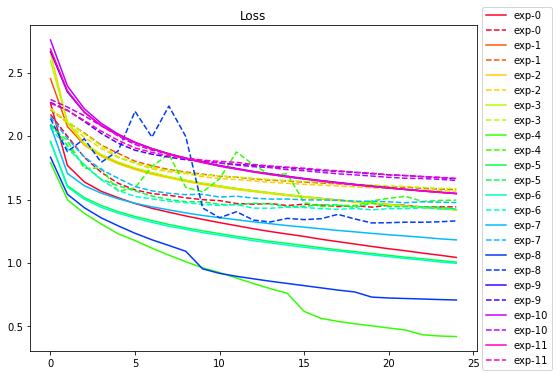

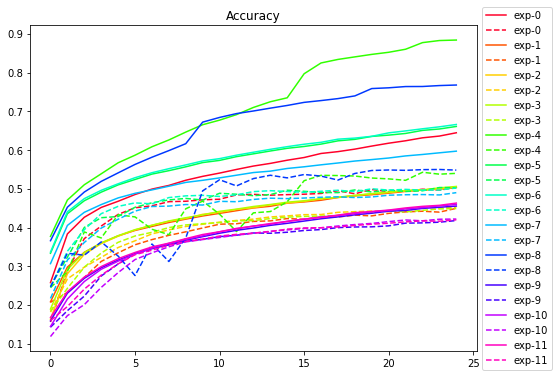

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()